<a href="https://colab.research.google.com/github/bubblebolt/dads/blob/main/DADS6003/Stock%20Forecast/6610412002_Stock_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="lightblue">Name: Chalita Iamleelaporn, Student ID: 6610412002 </font></b>

# Step 1: Import Libraries

In [ ]:
!pip install requests
!pip install lxml
!pip install yfinance
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [2]:
# Data Manipulation
import numpy as np
import pandas as pd
import yfinance as yf

# Technical Indicators
import talib as ta

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Step 2: Import Data

In [3]:
#นำเข้าข้อมูลหุ้น "กสิกร"
ptt = yf.Ticker('KBANK.bk')
interval = '1h'
start = '2023-11-01'
end = '2024-01-01'
df = ptt.history(interval=interval,start=start,end=end)
df = df.iloc[:,:5]
df

,Open,High,Low,Close,Volume
Datetime,,,,,
2023-11-01 10:00:00+07:00,131.5,133.0,131.5,132.5,0
2023-11-01 11:00:00+07:00,133.0,133.0,132.0,132.5,515022
2023-11-01 12:00:00+07:00,132.5,133.0,132.0,133.0,3664018
2023-11-01 14:00:00+07:00,132.5,133.0,132.0,132.5,606083
2023-11-01 15:00:00+07:00,132.5,133.0,131.5,131.5,2257793
...,...,...,...,...,...
2023-12-28 11:00:00+07:00,134.0,134.5,134.0,134.0,1419974
2023-12-28 12:00:00+07:00,134.0,134.5,134.0,134.5,947064
2023-12-28 14:00:00+07:00,134.5,135.0,134.0,135.0,4296994


# Step 3: Define Predictor/Independent Variables


In [4]:
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod=10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
X = df.iloc[:, :8]
X

,Open,High,Low,Close,Volume,S_10,Corr,RSI
Datetime,,,,,,,,
2023-11-06 10:00:00+07:00,133.5,133.5,132.0,132.5,0,133.10,0.311790,43.995817
2023-11-06 11:00:00+07:00,132.5,133.0,132.0,133.0,1634393,133.15,0.090723,51.058082
2023-11-06 12:00:00+07:00,133.0,133.0,132.5,133.0,268326,133.20,-0.268309,51.058082
2023-11-06 14:00:00+07:00,133.0,133.0,132.5,133.0,141606,133.20,-0.462870,51.058082
2023-11-06 15:00:00+07:00,133.0,133.0,132.5,133.0,513481,133.15,-0.395461,51.058082
...,...,...,...,...,...,...,...,...
2023-12-28 11:00:00+07:00,134.0,134.5,134.0,134.0,1419974,132.75,0.888868,68.990431
2023-12-28 12:00:00+07:00,134.0,134.5,134.0,134.5,947064,133.05,0.898925,72.295809
2023-12-28 14:00:00+07:00,134.5,135.0,134.0,135.0,4296994,133.35,0.918728,75.229520


# Step 4: Define Target/Dependent Variable

In [5]:
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)
y

array([ 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1,
       -1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
       -1,  1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,
       -1,  1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1,  1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1,
       -1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1, -1, -1,
       -1,  1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1, -1,  1,
       -1, -1,  1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1, -1,
       -1])

# Step 5: Split The Dataset

In [6]:
split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Step 6: Instantiate The Logistic Regression in Python


In [7]:
model = LogisticRegression()
model = model.fit (X_train,y_train)

# Step 7: Examine The Coefficients

In [8]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Open,[-0.0019048327951623578]
1,High,[-0.0019105327800879276]
2,Low,[-0.0019015331084916015]
3,Close,[-0.001909679903241453]
4,Volume,[2.111560000962335e-07]
5,S_10,[-0.0019009741088756478]
6,Corr,[3.23905005040827e-06]
7,RSI,[-0.0008196685198103807]


# Step 8: Calculate Class Probabilities


In [9]:
prediction_date = '2023-12-20'
probability = model.predict_proba(X_test)
print (probability)

[[0.76328678 0.23671322]
 [0.78053175 0.21946825]
 [0.7011389  0.2988611 ]
 [0.7582024  0.2417976 ]
 [0.7701208  0.2298792 ]
 [0.76176016 0.23823984]
 [0.75368666 0.24631334]
 [0.78472017 0.21527983]
 [0.73905905 0.26094095]
 [0.7386231  0.2613769 ]
 [0.71542689 0.28457311]
 [0.76257795 0.23742205]
 [0.70868512 0.29131488]
 [0.78242923 0.21757077]
 [0.76488981 0.23511019]
 [0.76245875 0.23754125]
 [0.78267172 0.21732828]
 [0.73939399 0.26060601]
 [0.76941351 0.23058649]
 [0.69522562 0.30477438]
 [0.76841266 0.23158734]
 [0.7760955  0.2239045 ]
 [0.77466975 0.22533025]
 [0.73461989 0.26538011]
 [0.76089155 0.23910845]
 [0.67156865 0.32843135]
 [0.76826443 0.23173557]
 [0.78094986 0.21905014]
 [0.7727506  0.2272494 ]
 [0.76724483 0.23275517]
 [0.77773646 0.22226354]
 [0.78732443 0.21267557]
 [0.76023917 0.23976083]
 [0.78523773 0.21476227]
 [0.75203394 0.24796606]
 [0.76396344 0.23603656]
 [0.78100287 0.21899713]
 [0.78502022 0.21497978]
 [0.76932537 0.23067463]
 [0.7834628  0.2165372 ]


In [10]:
predicted = model.predict(X_test)
print (predicted)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


# Step 10: Evaluate The Model


In [11]:
print(metrics.confusion_matrix(y_test, predicted))

[[44  0]
 [23  0]]


In [12]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.66      1.00      0.79        44
           1       0.00      0.00      0.00        23

    accuracy                           0.66        67
   macro avg       0.33      0.50      0.40        67
weighted avg       0.43      0.66      0.52        67



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Step 11: Create Trading Strategy Using The Model


<ipython-input-13-e276712736a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predicted_Signal'] = model.predict(X)
<ipython-input-13-e276712736a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['KBANK_returns'] = np.log(df['Close']/df['Close'].shift(1))
<ipython-input-13-e276712736a3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

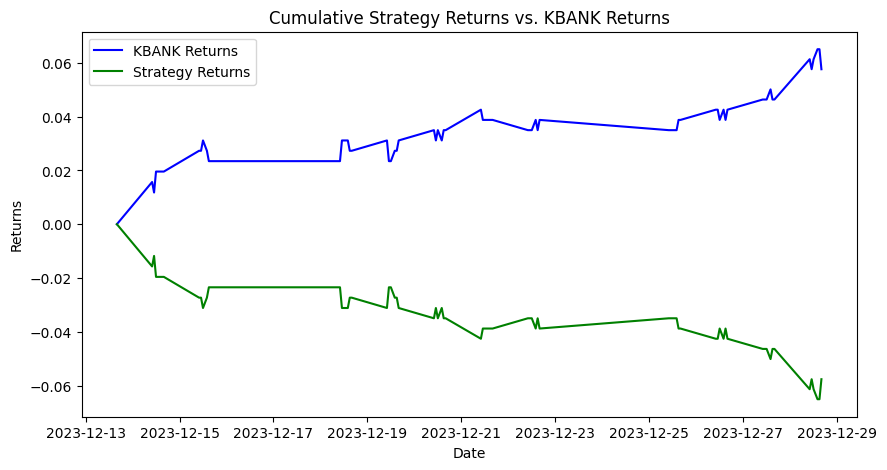

In [13]:
df['Predicted_Signal'] = model.predict(X)
df['KBANK_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_KBANK_returns = np.cumsum(df[split:]['KBANK_returns'])

df['Strategy_returns'] = df['KBANK_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Strategy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_KBANK_returns , color='b', label='KBANK Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label='Strategy Returns')
plt.legend()
plt.title('Cumulative Strategy Returns vs. KBANK Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

In [14]:
df

,Open,High,Low,Close,Volume,S_10,Corr,RSI,Open-Close,Open-Open,Predicted_Signal,KBANK_returns,Strategy_returns
Datetime,,,,,,,,,,,,,
2023-11-06 10:00:00+07:00,133.5,133.5,132.0,132.5,0,133.10,0.311790,43.995817,0.0,0.5,-1,NaN,NaN
2023-11-06 11:00:00+07:00,132.5,133.0,132.0,133.0,1634393,133.15,0.090723,51.058082,0.0,-1.0,-1,0.003766,-0.003766
2023-11-06 12:00:00+07:00,133.0,133.0,132.5,133.0,268326,133.20,-0.268309,51.058082,0.0,0.5,-1,0.000000,-0.000000
2023-11-06 14:00:00+07:00,133.0,133.0,132.5,133.0,141606,133.20,-0.462870,51.058082,0.0,0.0,-1,0.000000,-0.000000
2023-11-06 15:00:00+07:00,133.0,133.0,132.5,133.0,513481,133.15,-0.395461,51.058082,0.0,0.0,-1,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 11:00:00+07:00,134.0,134.5,134.0,134.0,1419974,132.75,0.888868,68.990431,-0.5,0.0,-1,-0.003724,0.003724
2023-12-28 12:00:00+07:00,134.0,134.5,134.0,134.5,947064,133.05,0.898925,72.295809,0.0,0.0,-1,0.003724,-0.003724
2023-12-28 14:00:00+07:00,134.5,135.0,134.0,135.0,4296994,133.35,0.918728,75.229520,0.0,0.5,-1,0.003711,-0.003711


# Step 12: Add feature (column)

In [15]:
# ดึงข้อมูล SET50 ดัชนีสะท้อนความเคลื่อนไหวของราคาหุ้น 50 ตัวแรก
set50 = yf.Ticker('^SET50.BK')
df_set50 = set50.history(interval=interval, start=start, end=end)
df_set50

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-11-01 10:00:00+07:00,857.090027,860.280029,854.619995,855.989990,0,0.0,0.0
2023-11-01 11:00:00+07:00,855.530029,855.530029,850.059998,854.159973,0,0.0,0.0
2023-11-01 12:00:00+07:00,853.940002,858.280029,853.609985,857.289978,0,0.0,0.0
2023-11-01 14:00:00+07:00,857.380005,858.369995,853.909973,855.250000,0,0.0,0.0
2023-11-01 15:00:00+07:00,855.169983,858.039978,852.309998,853.020020,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-28 11:00:00+07:00,876.700012,878.210022,875.140015,876.729980,0,0.0,0.0
2023-12-28 12:00:00+07:00,876.549988,877.650024,875.780029,876.700012,0,0.0,0.0
2023-12-28 14:00:00+07:00,877.119995,878.200012,876.380005,877.440002,0,0.0,0.0


In [16]:
# ดึงข้อมูล SET100 ดัชนีสะท้อนความเคลื่อนไหวของราคาหุ้น 100 ตัวแรก
set100 = yf.Ticker('^SET100.BK')
df_set100 = set100.history(interval=interval, start=start, end=end)
df_set100

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-11-01 10:00:00+07:00,1897.550049,1904.489990,1892.369995,1894.839966,0,0.0,0.0
2023-11-01 11:00:00+07:00,1888.939941,1893.810059,1882.119995,1891.760010,0,0.0,0.0
2023-11-01 12:00:00+07:00,1892.010010,1901.000000,1890.869995,1898.660034,0,0.0,0.0
2023-11-01 14:00:00+07:00,1898.989990,1900.920044,1891.260010,1893.619995,0,0.0,0.0
2023-11-01 15:00:00+07:00,1893.069946,1899.319946,1887.020020,1888.709961,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-28 11:00:00+07:00,1941.810059,1943.930054,1937.040039,1941.140015,0,0.0,0.0
2023-12-28 12:00:00+07:00,1940.790039,1943.140015,1939.150024,1941.050049,0,0.0,0.0
2023-12-28 14:00:00+07:00,1941.780029,1944.390015,1940.449951,1942.910034,0,0.0,0.0


In [17]:
# ดึงข้อมูล SET HD ดัชนีสะท้อนความเคลื่อนไหวของราคาหุ้น 30 ตัว
set_tri = yf.Ticker('^SETHD.BK')
df_set_hd = set_tri.history(interval=interval, start=start, end=end)
df_set_hd

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-11-01 10:00:00+07:00,1093.160034,1093.640015,1087.250000,1088.229980,0,0.0,0.0
2023-11-01 11:00:00+07:00,1089.020020,1089.020020,1080.530029,1085.239990,0,0.0,0.0
2023-11-01 12:00:00+07:00,1083.790039,1088.780029,1083.599976,1087.250000,0,0.0,0.0
2023-11-01 14:00:00+07:00,1087.579956,1087.739990,1081.569946,1083.109985,0,0.0,0.0
2023-11-01 15:00:00+07:00,1083.400024,1086.709961,1081.229980,1082.410034,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-28 11:00:00+07:00,1120.660034,1122.359985,1119.160034,1121.109985,0,0.0,0.0
2023-12-28 12:00:00+07:00,1120.030029,1123.400024,1119.599976,1121.579956,0,0.0,0.0
2023-12-28 14:00:00+07:00,1121.040039,1124.319946,1120.359985,1122.819946,0,0.0,0.0


In [18]:
# ดึงข้อมูล DJI ดัชนีอุตสาหกรรมดาวโจนส์
dji = yf.Ticker('^DJI')
df_dji = dji.history(interval=interval, start=start, end=end)
df_dji = df_dji.iloc[43:, :]
df_dji.index = df_set100.index
df_dji

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-11-01 10:00:00+07:00,34011.988281,34123.238281,33983.250000,34097.488281,34883493,0.0,0.0
2023-11-01 11:00:00+07:00,34097.328125,34125.500000,34082.761719,34084.480469,29640270,0.0,0.0
2023-11-01 12:00:00+07:00,34085.089844,34116.460938,33951.871094,34039.578125,26710098,0.0,0.0
2023-11-01 14:00:00+07:00,34038.648438,34047.781250,33878.250000,33929.539062,30009476,0.0,0.0
2023-11-01 15:00:00+07:00,33929.589844,33943.429688,33863.589844,33873.191406,30825600,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-28 11:00:00+07:00,37593.148438,37615.988281,37538.800781,37559.121094,20343050,0.0,0.0
2023-12-28 12:00:00+07:00,37559.230469,37662.679688,37556.371094,37618.351562,18970328,0.0,0.0
2023-12-28 14:00:00+07:00,37618.429688,37683.519531,37618.359375,37659.371094,16715404,0.0,0.0


In [19]:
df_new = df.iloc[:, :4]
df_new['SET50'] = df_set50['Close']
df_new['SET100'] = df_set100['Close']
df_new['SETHD'] = df_set_hd['Close']
df_new['DJI'] = df_dji['Close']
df_new = df_new.dropna()
X_new = df_new.iloc[:, :8]
X_new

,Open,High,Low,Close,SET50,SET100,SETHD,DJI
Datetime,,,,,,,,
2023-11-06 10:00:00+07:00,133.5,133.5,132.0,132.5,881.090027,1952.219971,1113.310059,34356.789062
2023-11-06 11:00:00+07:00,132.5,133.0,132.0,133.0,880.909973,1952.400024,1113.489990,34330.488281
2023-11-06 12:00:00+07:00,133.0,133.0,132.5,133.0,881.020020,1952.109985,1114.150024,34848.648438
2023-11-06 14:00:00+07:00,133.0,133.0,132.5,133.0,879.580017,1948.420044,1112.270020,34912.531250
2023-11-06 15:00:00+07:00,133.0,133.0,132.5,133.0,881.169983,1951.989990,1114.089966,34791.929688
...,...,...,...,...,...,...,...,...
2023-12-28 11:00:00+07:00,134.0,134.5,134.0,134.0,876.729980,1941.140015,1121.109985,37559.121094
2023-12-28 12:00:00+07:00,134.0,134.5,134.0,134.5,876.700012,1941.050049,1121.579956,37618.351562
2023-12-28 14:00:00+07:00,134.5,135.0,134.0,135.0,877.440002,1942.910034,1122.819946,37659.371094


In [20]:
y_new = np.where(df_new['Close'].shift(-1) > df_new['Close'],1,-1)

In [21]:
split = int(0.7*len(df_new))
Xn_train, Xn_test, yn_train, yn_test= X_new[:split], X_new[split:], y_new[:split], y_new[split:]
Xn_train

,Open,High,Low,Close,SET50,SET100,SETHD,DJI
Datetime,,,,,,,,
2023-11-06 10:00:00+07:00,133.5,133.5,132.0,132.5,881.090027,1952.219971,1113.310059,34356.789062
2023-11-06 11:00:00+07:00,132.5,133.0,132.0,133.0,880.909973,1952.400024,1113.489990,34330.488281
2023-11-06 12:00:00+07:00,133.0,133.0,132.5,133.0,881.020020,1952.109985,1114.150024,34848.648438
2023-11-06 14:00:00+07:00,133.0,133.0,132.5,133.0,879.580017,1948.420044,1112.270020,34912.531250
2023-11-06 15:00:00+07:00,133.0,133.0,132.5,133.0,881.169983,1951.989990,1114.089966,34791.929688
...,...,...,...,...,...,...,...,...
2023-12-13 10:00:00+07:00,127.5,128.0,127.5,128.0,843.190002,1866.300049,1082.839966,37207.609375
2023-12-13 11:00:00+07:00,127.5,128.0,127.5,127.5,843.400024,1867.270020,1082.770020,37261.699219
2023-12-13 12:00:00+07:00,127.5,128.0,127.5,127.5,841.880005,1863.030029,1082.319946,37183.531250


In [22]:
model = LogisticRegression()
model = model.fit (Xn_train,yn_train)

In [23]:
pd.DataFrame(zip(X_new.columns, np.transpose(model.coef_)))

,0,1
0,Open,[-0.0458052276249567]
1,High,[-0.03876169997229031]
2,Low,[-0.08799300104354113]
3,Close,[-0.13144266953134065]
4,SET50,[0.0006457468829167081]
5,SET100,[-0.012792679017011383]
6,SETHD,[0.07008137465884838]
7,DJI,[-0.00040513203305589526]


In [24]:
probability = model.predict_proba(Xn_test)
print (probability)

[[0.76211913 0.23788087]
 [0.81381765 0.18618235]
 [0.81484353 0.18515647]
 [0.83846089 0.16153911]
 [0.86973104 0.13026896]
 [0.86355166 0.13644834]
 [0.87075291 0.12924709]
 [0.80978891 0.19021109]
 [0.83650331 0.16349669]
 [0.85237603 0.14762397]
 [0.83397869 0.16602131]
 [0.8323644  0.1676356 ]
 [0.83932139 0.16067861]
 [0.78860609 0.21139391]
 [0.82378002 0.17621998]
 [0.84572368 0.15427632]
 [0.8513449  0.1486551 ]
 [0.85179582 0.14820418]
 [0.84933254 0.15066746]
 [0.84854655 0.15145345]
 [0.85349008 0.14650992]
 [0.84296952 0.15703048]
 [0.82218747 0.17781253]
 [0.80932477 0.19067523]
 [0.83427116 0.16572884]
 [0.82287833 0.17712167]
 [0.81088041 0.18911959]
 [0.79267281 0.20732719]
 [0.80949991 0.19050009]
 [0.82895304 0.17104696]
 [0.81102872 0.18897128]
 [0.85116901 0.14883099]
 [0.84914313 0.15085687]
 [0.84374851 0.15625149]
 [0.83569039 0.16430961]
 [0.83757643 0.16242357]
 [0.83215285 0.16784715]
 [0.85033632 0.14966368]
 [0.83474421 0.16525579]
 [0.8568525  0.1431475 ]


In [25]:
predicted_new = model.predict(Xn_test)
print (predicted)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [26]:
print(metrics.classification_report(yn_test, predicted_new))

              precision    recall  f1-score   support

          -1       0.66      1.00      0.79        44
           1       0.00      0.00      0.00        23

    accuracy                           0.66        67
   macro avg       0.33      0.50      0.40        67
weighted avg       0.43      0.66      0.52        67



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-27-031dc32106c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predicted_New_Signal'] = model.predict(X_new)
<ipython-input-27-031dc32106c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['KBANK_New_returns'] = np.log(df_new['Close']/df_new['Close'].shift(1))


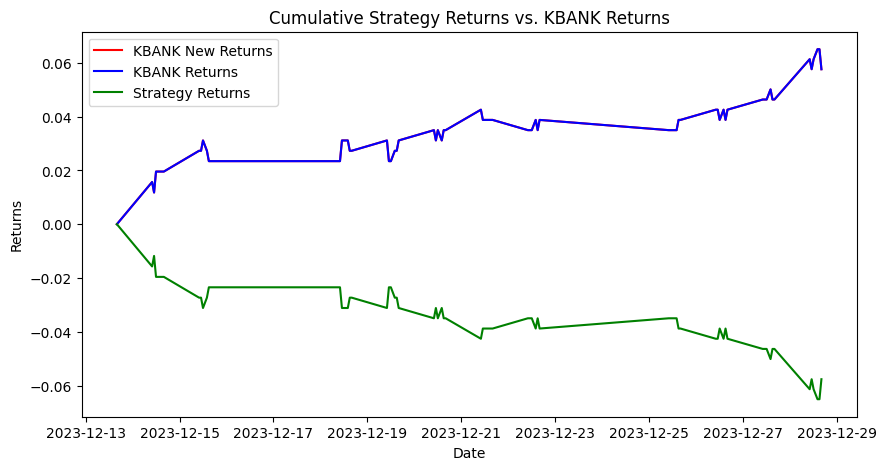

In [27]:
#New Model
df['Predicted_New_Signal'] = model.predict(X_new)
df['KBANK_New_returns'] = np.log(df_new['Close']/df_new['Close'].shift(1))
Cumulative_New_KBANK_returns = np.cumsum(df[split:]['KBANK_New_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_New_KBANK_returns , color='r', label='KBANK New Returns')
plt.plot(Cumulative_KBANK_returns , color='b', label='KBANK Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label='Strategy Returns')
plt.legend()
plt.title('Cumulative Strategy Returns vs. KBANK Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

In [28]:
df

,Open,High,Low,Close,Volume,S_10,Corr,RSI,Open-Close,Open-Open,Predicted_Signal,KBANK_returns,Strategy_returns,Predicted_New_Signal,KBANK_New_returns
Datetime,,,,,,,,,,,,,,,
2023-11-06 10:00:00+07:00,133.5,133.5,132.0,132.5,0,133.10,0.311790,43.995817,0.0,0.5,-1,NaN,NaN,-1,NaN
2023-11-06 11:00:00+07:00,132.5,133.0,132.0,133.0,1634393,133.15,0.090723,51.058082,0.0,-1.0,-1,0.003766,-0.003766,-1,0.003766
2023-11-06 12:00:00+07:00,133.0,133.0,132.5,133.0,268326,133.20,-0.268309,51.058082,0.0,0.5,-1,0.000000,-0.000000,-1,0.000000
2023-11-06 14:00:00+07:00,133.0,133.0,132.5,133.0,141606,133.20,-0.462870,51.058082,0.0,0.0,-1,0.000000,-0.000000,-1,0.000000
2023-11-06 15:00:00+07:00,133.0,133.0,132.5,133.0,513481,133.15,-0.395461,51.058082,0.0,0.0,-1,0.000000,-0.000000,-1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28 11:00:00+07:00,134.0,134.5,134.0,134.0,1419974,132.75,0.888868,68.990431,-0.5,0.0,-1,-0.003724,0.003724,-1,-0.003724
2023-12-28 12:00:00+07:00,134.0,134.5,134.0,134.5,947064,133.05,0.898925,72.295809,0.0,0.0,-1,0.003724,-0.003724,-1,0.003724
2023-12-28 14:00:00+07:00,134.5,135.0,134.0,135.0,4296994,133.35,0.918728,75.229520,0.0,0.5,-1,0.003711,-0.003711,-1,0.003711


In [29]:
from sklearn.metrics import classification_report

print("Old Model:\n", classification_report(y_test, predicted))
print("New Model:\n", classification_report(yn_test, predicted_new))

Old Model:
               precision    recall  f1-score   support

          -1       0.66      1.00      0.79        44
           1       0.00      0.00      0.00        23

    accuracy                           0.66        67
   macro avg       0.33      0.50      0.40        67
weighted avg       0.43      0.66      0.52        67

New Model:
               precision    recall  f1-score   support

          -1       0.66      1.00      0.79        44
           1       0.00      0.00      0.00        23

    accuracy                           0.66        67
   macro avg       0.33      0.50      0.40        67
weighted avg       0.43      0.66      0.52        67



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

<b><font color="lightblue">การเพิ่ม Feature  ใหม่ (โดยไม่ใช้คุณลักษณะเก่าเลย) ซึ่ง Feature  ที่เพิ่มได้แก่ Set50, Set100, SetHD, DJI

ทำให้โมเดลมีความแม่นยำเพิ่มขึ้นจาก 0.64 เป็น 0.66</font></b>
